In [27]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from collections import Counter

import time
import warnings
# warnings.filterwarnings('ignore')

## Data Processing

In [28]:
def data_processor(oversampling=False,dist=0):
    df = pd.read_csv('Datasets/train.csv', sep='|')
#     features_to_select = ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
#                           'scansWithoutRegistration', 'quantityModifications', 
#                           'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'P_fraud']
    features_to_select = ['trustLevel', 'totalScanTimeInSeconds', 'lineItemVoids',
                          'scansWithoutRegistration', 'quantityModifications', 
                          'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition']
    
    # Implementando a função de Filipe
#     df['f_x_i'] =  -2.125-6.008*df['trustLevel']+0.004*df['totalScanTimeInSeconds']
#     df['f_x_i'] = df['f_x_i'] +0.016*df['grandTotal']+3.020*df['lineItemVoids']
#     df['f_x_i'] = df['f_x_i'] +0.466*df['scansWithoutRegistration']-62.226*df['lineItemVoidsPerPosition'] 
#     df['P_Y_i'] = 1.0/(1+np.exp(-df['f_x_i']))
#     df['P_fraud'] = round(df['P_Y_i'] )
    
#     df = df[['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
#                           'scansWithoutRegistration', 'quantityModifications', 
#                           'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'P_fraud'] + ['fraud']]
    
#     print('Use StandardScaler to process the column data')
#     scaler = StandardScaler()
    scaler = RobustScaler()
    df[df.columns[:-1].tolist()] = scaler.fit_transform(df[df.columns[:-1].tolist()])
    # print(df.head(5))
    X = df[df.columns[:-1].tolist()]
    X = X[features_to_select]
    y = df[df.columns[-1]]

#     print("Train Test Split ratio is 0.33")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=dist, stratify=y)
    
    if (oversampling == True): # Baseado em https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
        df_train = X_train.join(y_train) # .reset_index(drop=True)
        # Class count
        count_class_0, count_class_1 = df_train.fraud.value_counts()

        # Divide by class
        df_class_0 = df_train[df_train['fraud'] == 0]
        df_class_1 = df_train[df_train['fraud'] == 1]

        df_class_1_over = df_class_1.sample(count_class_0, replace=True)
        df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

        print('Random over-sampling:')
        print(df_test_over.fraud.value_counts())

        df_test_over.fraud.value_counts().plot(kind='bar', title='Count (fraud)')   

        X_train = df_test_over[features_to_select]
        y_train = df_test_over[df_test_over.columns[-1]]
    
#     print(f"X_train shape: {X_train.shape}")
#     print(f"y_train shape: {y_train.shape}")
#     print(f"True class percentage in train set: {100*y_train.sum()/y_train.count()}%")
    
#     print(f"X_test shape: {X_test.shape}")
#     print(f"y_test shape: {y_test.shape}")
#     print(f"True class percentage in test set: {100*y_test.sum()/y_test.count()}%")

    return X_train, X_test, y_train, y_test

## Objective and Evaluation Functions

In [29]:
# baseado em https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py
# user define objective function, given prediction, return gradient and second order gradient
# this is log likelihood loss

# Definição da função objetivo 'binary:logistic' padrão do xgboost
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
#     preds = 1.0 / (1.0 + np.exp(-preds)) # Esta linha está comentada devido a isso: https://github.com/dmlc/xgboost/issues/3892#issuecomment-441214227
    grad = preds - labels
    hess = preds * (1.0 - preds)
    return grad, hess

# def logreg_objective(y_true, y_pred):
#     weights = np.where(y_true == 1.0, 1.0, 1.0)
# #     y_pred = 1.0 / (1.0 + np.exp(-y_pred))
#     grad = y_pred - y_true
#     hess = y_pred * (1.0 - y_pred)
#     return grad * weights, hess *  weights


def logreg_objective(y_true, y_pred):
    weights = np.where(y_true == 1.0, 1.0, 1.0)
#     y_pred = 1.0 / (1.0 + np.exp(-y_pred))
    grad = y_pred - y_true
    hess = y_pred * (1.0 - y_pred)
    return grad * weights, hess *  weights


# def logreg_objective(y_true, y_pred): # RICARDO
# #     Soff =  35*T*P -5*T -25*P +25,0000001 
# #     OBJ = 1/ ( Soff) 
# #     G = -(Soff)^(-2) * (35*T-25)
# #     H = 2*(Soff)^(-3) * (35*T-25)^(2)
#     weights = np.where(y_true == 1.0, 1.0, 1.0)
# #     y_pred = 1.0 / (1.0 + np.exp(-y_pred))
# #     soff = 35*y_true*y_pred -5*y_true -25*y_pred +27
# #     inter = 35*y_true-25
#     soff = -35*y_true*y_pred + 5*y_true + 25*y_pred -27
#     inter = -35*y_true+25
#     grad = -(soff)**(-2) * (inter)
#     hess = 2*((soff)**(-3)) * ((inter)**(2))
#     return grad * weights, hess *  weights



# user defined evaluation function, return a pair metric_name, result
# NOTE: when you do customized loss function, the default prediction value is margin
# this may make builtin evaluation metric not function properly
# for example, we are doing logistic loss, the prediction is score before logistic transformation
# the builtin evaluation error assumes input is after logistic transformation
# Take this in mind when you use the customization, and maybe you need write customized evaluation function

# Definição da função de avaliação para a DMC 2019
def cupEvalScore(y_predicted, y_true):
    labels = y_true.get_label()
    y_predicted = np.round(y_predicted)
    matrix = metrics.confusion_matrix(labels, y_predicted)
    weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-25,-5,5]))
    return 'cupScore', weightSum

def cupEvalScore_negative(y_predicted, y_true): # versão negativa da função
    labels = y_true.get_label()
    y_predicted = np.round(y_predicted)
    matrix = metrics.confusion_matrix(labels, y_predicted)
    weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,25,5,-5]))
    return 'cupScore', weightSum

def cupEvalScoreNorm_negative(y_predicted, y_true): # versão negativa da função
    labels = y_true.get_label()
    y_predicted = np.round(y_predicted)
    matrix = metrics.confusion_matrix(labels, y_predicted)
    totalArray = np.reshape(matrix, 4)
    weightSum = np.sum(totalArray*np.array([0,25,5,-5]))/np.sum(totalArray)
    return 'cupScore', weightSum

# training with customized objective, we can also do step by step training
# simply look at xgboost.py's implementation of train
# bst = xgb.train(param, dtrain, num_round, watchlist, obj=logregobj, feval=evalerror)

## Training, Prediction and Results

In [32]:
def xgb_classifier(X_train, X_test, y_train, y_test, useTrainCV=False, cv_folds=3, early_stopping_rounds=10):
    # Definindo o classificador xGBoost com função objetivo (objective=logreg_objective) 
    # e função de avaliação (feval=cupEvalScore_negative)
    alg = XGBClassifier(booster='gbtree', 
                        learning_rate=0.01, n_estimators=9001, max_depth=20,
                        min_child_weight=2, gamma=0.2, subsample=0.2, colsample_bytree=1.0,
                        objective=logreg_objective, feval=cupEvalScoreNorm_negative,
                        nthread=7, scale_pos_weight=1, seed=27)

    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        print(alg.get_xgb_params())
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        # xgtest = xgb.DMatrix(X_test.values, label=y_test.values)
        print('running cross validation')
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          verbose_eval=1000, stratified=True,
                          feval=cupEvalScore_negative, maximize=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(alg.get_xgb_params())
        print('Best number of trees = {}\n'.format(cvresult.shape[0]))
#         print(cvresult)

#     print('\nStart Training')
#     print('xGBoost params:', alg.get_xgb_params(), '\n')
    alg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=cupEvalScoreNorm_negative, verbose=False)
#     alg.fit(X_train, y_train, verbose=1000)

    print("\nStart Predicting")
    predictions = alg.predict(X_test)
    pred_proba = alg.predict_proba(X_test)[:, 1]

    print("Acurracy: %.4g" % metrics.accuracy_score(y_test, predictions))
    print("AUC: %f" % metrics.roc_auc_score(y_test, predictions))
    print("AUC_prob: %f" % metrics.roc_auc_score(y_test, pred_proba))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
#     print (false_positive_rate[1], true_positive_rate[1], auc(false_positive_rate, true_positive_rate))
    print("F1 Score: %f" % metrics.f1_score(y_test, predictions))
    matrix = metrics.confusion_matrix(y_test, predictions)
    weightSum = np.sum(np.reshape(matrix, 4)*np.array([0,-25,-5,5]))
    totalArray = np.reshape(matrix, 4)
    print(f"Score Cup: {weightSum}")
    print(f"Score Cup Norm: {weightSum/np.sum(totalArray)}")
    print(f"Confusion matrix: \n{matrix}")
    print(f"Percentage of positives: \n{100*np.sum(totalArray*np.array([0,1,0,1]))/np.sum(totalArray)}")
    print(f"Real positives: \n{100*np.sum(totalArray*np.array([0,0,1,1]))/np.sum(totalArray)}")

    feat_imp = alg.feature_importances_
    feat = X_train.columns.tolist()
    # clf.best_estimator_.booster().get_fscore()
    res_df = pd.DataFrame({'Features': feat, 'Importance': feat_imp}).sort_values(by='Importance', ascending=False)
    res_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    print(res_df)
    print(res_df["Features"].tolist())




 RODADA  0 


Start Predicting
Acurracy: 0.9855
AUC: 0.923063
AUC_prob: 0.982062
F1 Score: 0.865672
Score Cup: 20
Confusion matrix: 
[[583   4]
 [  5  29]]
Percentage of positives: 
5.314009661835748
Real positives: 
5.475040257648954


                    Features  Importance
9                    P_fraud    0.376350
0                 trustLevel    0.116644
4   scansWithoutRegistration    0.072141
1     totalScanTimeInSeconds    0.070975
6  scannedLineItemsPerSecond    0.066072
3              lineItemVoids    0.064080
2                 grandTotal    0.060113
7             valuePerSecond    0.059065
5      quantityModifications    0.058009
8   lineItemVoidsPerPosition    0.056549
['P_fraud', 'trustLevel', 'scansWithoutRegistration', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'lineItemVoids', 'grandTotal', 'valuePerSecond', 'quantityModifications', 'lineItemVoidsPerPosition']



 RODADA  1 


Start Predicting
Acurracy: 0.9839
AUC: 0.894503
AUC_prob: 0.976751
F1 Score: 0.843750
Score Cup: 25
Confusion matrix: 
[[584   3]
 [  7  27]]
Percentage of positives: 
4.830917874396135
Real positives: 
5.475040257648954


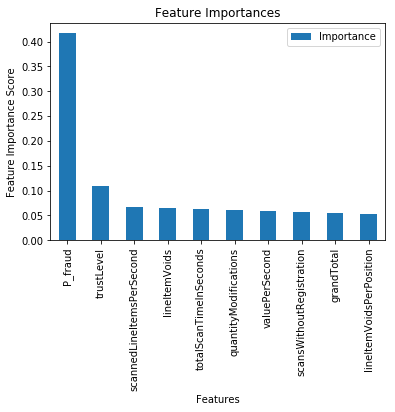

                    Features  Importance
9                    P_fraud    0.417011
0                 trustLevel    0.108448
6  scannedLineItemsPerSecond    0.066610
3              lineItemVoids    0.063878
1     totalScanTimeInSeconds    0.061781
5      quantityModifications    0.060357
7             valuePerSecond    0.058291
4   scansWithoutRegistration    0.056012
2                 grandTotal    0.055123
8   lineItemVoidsPerPosition    0.052490
['P_fraud', 'trustLevel', 'scannedLineItemsPerSecond', 'lineItemVoids', 'totalScanTimeInSeconds', 'quantityModifications', 'valuePerSecond', 'scansWithoutRegistration', 'grandTotal', 'lineItemVoidsPerPosition']



 RODADA  2 


Start Predicting
Acurracy: 0.9871
AUC: 0.937769
AUC_prob: 0.982012
F1 Score: 0.882353
Score Cup: 30
Confusion matrix: 
[[583   4]
 [  4  30]]
Percentage of positives: 
5.475040257648954
Real positives: 
5.475040257648954


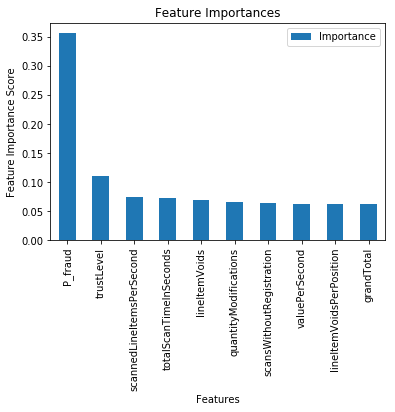

                    Features  Importance
9                    P_fraud    0.356688
0                 trustLevel    0.111341
6  scannedLineItemsPerSecond    0.073772
1     totalScanTimeInSeconds    0.071989
3              lineItemVoids    0.068619
5      quantityModifications    0.066380
4   scansWithoutRegistration    0.064027
7             valuePerSecond    0.062983
8   lineItemVoidsPerPosition    0.062585
2                 grandTotal    0.061618
['P_fraud', 'trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoids', 'quantityModifications', 'scansWithoutRegistration', 'valuePerSecond', 'lineItemVoidsPerPosition', 'grandTotal']



 RODADA  3 


Start Predicting
Acurracy: 0.9855
AUC: 0.950772
AUC_prob: 0.993236
F1 Score: 0.873239
Score Cup: -10
Confusion matrix: 
[[581   6]
 [  3  31]]
Percentage of positives: 
5.958132045088567
Real positives: 
5.475040257648954


                    Features  Importance
9                    P_fraud    0.336236
0                 trustLevel    0.110290
6  scannedLineItemsPerSecond    0.077718
1     totalScanTimeInSeconds    0.072800
3              lineItemVoids    0.070675
5      quantityModifications    0.069204
2                 grandTotal    0.068999
7             valuePerSecond    0.066847
8   lineItemVoidsPerPosition    0.063879
4   scansWithoutRegistration    0.063350
['P_fraud', 'trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoids', 'quantityModifications', 'grandTotal', 'valuePerSecond', 'lineItemVoidsPerPosition', 'scansWithoutRegistration']



 RODADA  4 


Start Predicting
Acurracy: 0.9887
AUC: 0.966329
AUC_prob: 0.996493
F1 Score: 0.901408
Score Cup: 25
Confusion matrix: 
[[582   5]
 [  2  32]]
Percentage of positives: 
5.958132045088567
Real positives: 
5.475040257648954


                    Features  Importance
9                    P_fraud    0.305613
0                 trustLevel    0.112087
7             valuePerSecond    0.077651
6  scannedLineItemsPerSecond    0.076102
1     totalScanTimeInSeconds    0.074853
3              lineItemVoids    0.073385
5      quantityModifications    0.072214
8   lineItemVoidsPerPosition    0.071573
2                 grandTotal    0.070302
4   scansWithoutRegistration    0.066221
['P_fraud', 'trustLevel', 'valuePerSecond', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoids', 'quantityModifications', 'lineItemVoidsPerPosition', 'grandTotal', 'scansWithoutRegistration']



 RODADA  5 


Start Predicting
Acurracy: 0.9839
AUC: 0.936066
AUC_prob: 0.989578
F1 Score: 0.857143
Score Cup: -20
Confusion matrix: 
[[581   6]
 [  4  30]]
Percentage of positives: 
5.797101449275362
Real positives: 
5.475040257648954


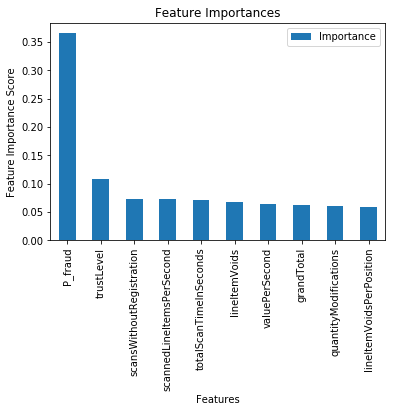

                    Features  Importance
9                    P_fraud    0.365670
0                 trustLevel    0.108500
4   scansWithoutRegistration    0.073112
6  scannedLineItemsPerSecond    0.072224
1     totalScanTimeInSeconds    0.070536
3              lineItemVoids    0.066769
7             valuePerSecond    0.063290
2                 grandTotal    0.061907
5      quantityModifications    0.060081
8   lineItemVoidsPerPosition    0.057911
['P_fraud', 'trustLevel', 'scansWithoutRegistration', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoids', 'valuePerSecond', 'grandTotal', 'quantityModifications', 'lineItemVoidsPerPosition']



 RODADA  6 


Start Predicting
Acurracy: 0.9807
AUC: 0.865092
AUC_prob: 0.972542
F1 Score: 0.806452
Score Cup: 5
Confusion matrix: 
[[584   3]
 [  9  25]]
Percentage of positives: 
4.508856682769726
Real positives: 
5.475040257648954


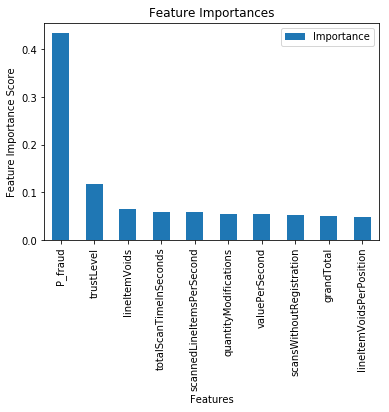

                    Features  Importance
9                    P_fraud    0.434075
0                 trustLevel    0.118256
3              lineItemVoids    0.065713
1     totalScanTimeInSeconds    0.060008
6  scannedLineItemsPerSecond    0.059050
5      quantityModifications    0.055217
7             valuePerSecond    0.055131
4   scansWithoutRegistration    0.052594
2                 grandTotal    0.050633
8   lineItemVoidsPerPosition    0.049324
['P_fraud', 'trustLevel', 'lineItemVoids', 'totalScanTimeInSeconds', 'scannedLineItemsPerSecond', 'quantityModifications', 'valuePerSecond', 'scansWithoutRegistration', 'grandTotal', 'lineItemVoidsPerPosition']



 RODADA  7 


Start Predicting
Acurracy: 0.9823
AUC: 0.949068
AUC_prob: 0.979407
F1 Score: 0.849315
Score Cup: -60
Confusion matrix: 
[[579   8]
 [  3  31]]
Percentage of positives: 
6.280193236714976
Real positives: 
5.475040257648954


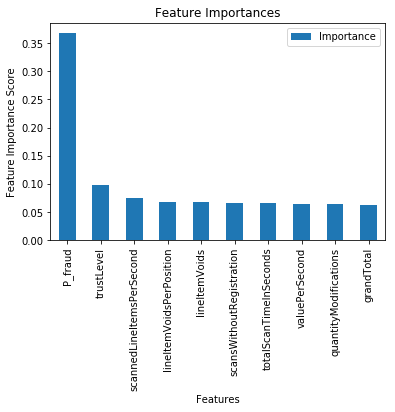

                    Features  Importance
9                    P_fraud    0.367976
0                 trustLevel    0.097422
6  scannedLineItemsPerSecond    0.074767
8   lineItemVoidsPerPosition    0.068142
3              lineItemVoids    0.067094
4   scansWithoutRegistration    0.066795
1     totalScanTimeInSeconds    0.066325
7             valuePerSecond    0.064272
5      quantityModifications    0.064062
2                 grandTotal    0.063145
['P_fraud', 'trustLevel', 'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition', 'lineItemVoids', 'scansWithoutRegistration', 'totalScanTimeInSeconds', 'valuePerSecond', 'quantityModifications', 'grandTotal']



 RODADA  8 


Start Predicting
Acurracy: 0.9871
AUC: 0.923915
AUC_prob: 0.984918
F1 Score: 0.878788
Score Cup: 45
Confusion matrix: 
[[584   3]
 [  5  29]]
Percentage of positives: 
5.152979066022544
Real positives: 
5.475040257648954


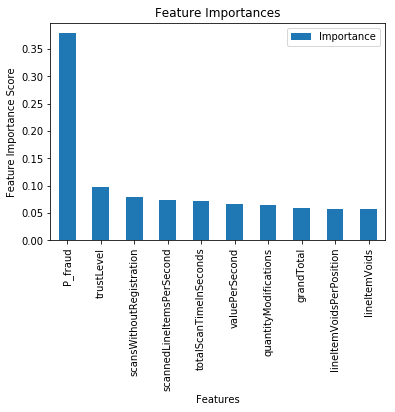

                    Features  Importance
9                    P_fraud    0.379101
0                 trustLevel    0.096617
4   scansWithoutRegistration    0.078301
6  scannedLineItemsPerSecond    0.072810
1     totalScanTimeInSeconds    0.071461
7             valuePerSecond    0.066009
5      quantityModifications    0.064102
2                 grandTotal    0.058134
8   lineItemVoidsPerPosition    0.056759
3              lineItemVoids    0.056706
['P_fraud', 'trustLevel', 'scansWithoutRegistration', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'valuePerSecond', 'quantityModifications', 'grandTotal', 'lineItemVoidsPerPosition', 'lineItemVoids']



 RODADA  9 


Start Predicting
Acurracy: 0.9887
AUC: 0.938621
AUC_prob: 0.989277
F1 Score: 0.895522
Score Cup: 55
Confusion matrix: 
[[584   3]
 [  4  30]]
Percentage of positives: 
5.314009661835748
Real positives: 
5.475040257648954


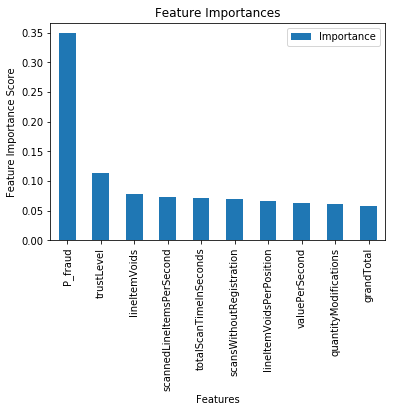

                    Features  Importance
9                    P_fraud    0.349065
0                 trustLevel    0.112602
3              lineItemVoids    0.078172
6  scannedLineItemsPerSecond    0.073424
1     totalScanTimeInSeconds    0.070792
4   scansWithoutRegistration    0.069175
8   lineItemVoidsPerPosition    0.065696
7             valuePerSecond    0.062274
5      quantityModifications    0.060939
2                 grandTotal    0.057861
['P_fraud', 'trustLevel', 'lineItemVoids', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'scansWithoutRegistration', 'lineItemVoidsPerPosition', 'valuePerSecond', 'quantityModifications', 'grandTotal']
Total Time is:  8.786677054564159


In [31]:
if __name__ == "__main__":
    start = time.time()
    for count in range(10):
        print('\n\n\n RODADA ', count, '\n')
        X_train, X_test, y_train, y_test = data_processor(dist=count)
        xgb_classifier(X_train, X_test, y_train, y_test)

print("Total Time is: ", (time.time() - start)/60)